In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
import sklearn.cluster as cluster
from scipy import stats

In [2]:
def read(filename):
    '''
    Returns two dataframes after reading the file given by filename
    '''
    df = pd.read_excel(filename,skiprows=3)
    labels = ['Country Code', 'Indicator Name','Indicator Code']
    years = df.set_index('Country Name').drop(labels=labels,axis=1)
    countries = years.transpose()
    return years, countries

In [3]:
def rm_out(df_in):
    '''
    Removes outliers from the data
    '''
    return  df_in[(np.abs(stats.zscore(df_in)) < 3).all(axis=1)]

In [4]:
def normalize(a):
    '''
    normalizes the data
    '''
    n=(a - a.min()) / (a.max() - a.min())
    return (n)

In [5]:
def err_ranges(x, func, param, sigma):
    """
    Calculates the upper and lower limits for the function, parameters and
    sigmas for single value or array x. Functions values are calculated for 
    all combinations of +/- sigma and the minimum and maximum is determined.
    Can be used for all number of parameters and sigmas >=1.
    
    This routine can be used in assignment programs.
    """

    import itertools as iter
    
    # initiate arrays for lower and upper limits
    lower = func(x, *param)
    upper = lower
    
    uplow = []   # list to hold upper and lower limits for parameters
    for p,s in zip(param, sigma):
        pmin = p - s
        pmax = p + s
        uplow.append((pmin, pmax))
        
    pmix = list(iter.product(*uplow))
    
    for p in pmix:
        y = func(x, *p)
        lower = np.minimum(lower, y)
        upper = np.maximum(upper, y)
        
    return lower, upper   

In [6]:
def make_clusters(x,y,n_clusters=3,column_names=[0,1]):
    '''
    Makes clusters of the data and plots the clusters with different colors
    '''
    df = rm_out(pd.concat([x, y], axis=1,keys=column_names).dropna())
    
    kmeans = cluster.KMeans(n_clusters=n_clusters)
    
    x = df[column_names[0]].values.reshape(-1, 1)
    y = df[column_names[1]].values
    
    norm_x = normalize(x)
    norm_y = normalize(y)
    
    kmeans.fit(norm_x,norm_y)
    cen = kmeans.cluster_centers_
    labels = kmeans.labels_
    
    colors = ["blue", "red", "green","orange"]
    for l in range(len(cen)):
        plt.plot(x[labels==l], y[labels==l], "+", color=colors[l])
    plt.xlabel(column_names[0])
    plt.ylabel(column_names[1])    
    plt.show()

In [7]:
#Reading data
co1,co2 = read('API_EN.ATM.GHGT.KT.CE_DS2_en_excel_v2_4026021.xls')

In [8]:
gdp1,gdp2 = read('API_NY.GDP.PCAP.CD_DS2_en_excel_v2_4021477.xls')

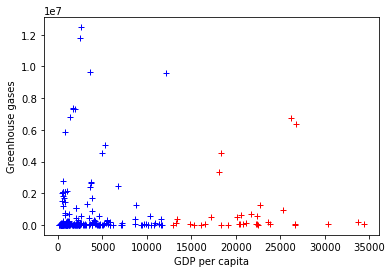

In [9]:
make_clusters(gdp2.mean(), co2.mean(),n_clusters=2,column_names=['GDP per capita', 'Greenhouse gases'])

The above plot shows clusterings of Greenhouse gases and GDP per capita data. The clusters are mainly made wrt GDP per capita. It is evident that countries with low GDP per capita shown in blue release more greenhouse gases than countries with higher GDP per capita shown in red. 

In [10]:
forest1,forest2 = read('API_AG.LND.FRST.ZS_DS2_en_excel_v2_4020478.xls')

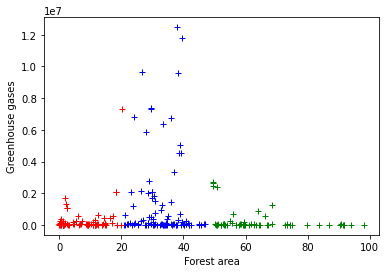

In [11]:
make_clusters(forest2.mean(), co2.mean(),column_names=['Forest area', 'Greenhouse gases'])

The above graph shows clusters made of forest area and greenhouse gases. We can see that the clusters are separated by defined boundaries. First cluster is from 0%-20% next is from 20%-50% and the last from 50%-100%. One thing to note is that the blue cluster was the one that had the most greenhouse gas emissions.

In [12]:
def quadratic(t, x0, h,x1, b):
    """Calculates the logistic function with scale factor n0 and growth rate g"""
    
    f = x0 * np.power(t - h,2) + x1*t + b
    
    return f

In [13]:
def rms(orig, pred):
    rms = np.sqrt(np.mean((orig-pred)**2))
    return rms

In [14]:
def fit(func, x_values,y_values,xlabel = None,ylabel=None,time=10):
    '''
    optimizes the function given and plots predicted and original data
    return rmse of the predictions
    '''
    popt, pcov = curve_fit(func, x_values, y_values,maxfev = 5000)
    y_pred = func(np.arange(x_values[0],x_values[-1]+time),*popt)
    plt.plot(np.arange(x_values[0],x_values[-1]+time),y_pred)
    plt.plot(x_values,y_values)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(['Predicted', 'Original'])
    
    plt.show()
    return rms(y_values,func(x_values,*popt))

In [15]:
eng1,eng2 = read('API_EG.USE.PCAP.KG.OE_DS2_en_excel_v2_4027677.xls')

In [16]:
x_values = np.array([int(x) for x in  co2['United States'].dropna().index])
y_values = co2['United States'].dropna().values

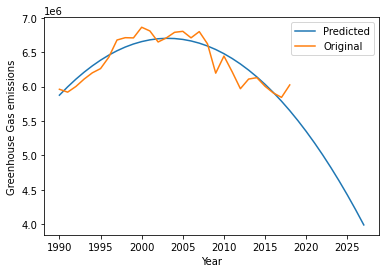

RMSE = 152253.8131718939


In [17]:
rmse = fit(quadratic,x_values,y_values,xlabel='Year',ylabel='Greenhouse Gas emissions')
print(f'RMSE = {rmse}')

In [18]:
x_values = np.array([int(x) for x in  eng2['United States'].dropna().index])
y_values = eng2['United States'].dropna().values

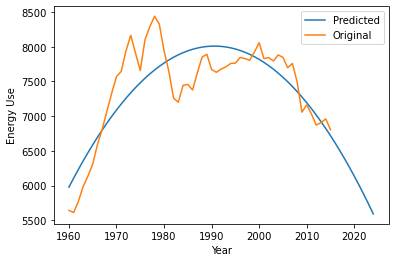

RMSE = 368.04571956658975


In [19]:
rmse = fit(quadratic,x_values,y_values,xlabel='Year',ylabel='Energy Use',time=10)
print(f'RMSE = {rmse}')